In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import h5py
from data_io import DataIO
import sklearn
import glob
import os
import cv2

In [2]:
!which python

/sw/arch/Debian10/EB_production/2019/software/Python/3.6.6-foss-2019b/bin/python


In [3]:
tf.__version__

'2.2.0'

In [4]:
!ls -lah models_saved

total 1.6G
drwx------ 2 maxwellc maxwellc 4.0K Jun  2 15:32 .
drwx------ 9 maxwellc maxwellc 4.0K Jun  3 15:36 ..
-rw------- 1 maxwellc maxwellc 125K Jun  2 15:32 label_encoder_classes.npy
-rw------- 1 maxwellc maxwellc  62M Jun  2 14:59 model_1024_EfficientNetB0_np_8.h5
-rw------- 1 maxwellc maxwellc 764M May 30 13:09 model_512_EfficientNetB7_np_4.h5
-rw------- 1 maxwellc maxwellc 737M May 27 15:59 model_512_EfficientNetB7_np_8.h5


In [5]:
img_size = 512

In [6]:
from deep_galaxy_training import DeepGalaxyTraining
# model = tf.keras.models.load_model('model_1024_EfficientNetB0_np_8.h5')
model = tf.keras.models.load_model('models_saved/model_512_EfficientNetB7_np_4.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 512, 512, 3)       0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 512, 512, 3)       0         
_________________________________________________________________
efficientnet-b7 (Model)      (None, 994)               66643314  
Total params: 66,643,314
Trainable params: 66,332,594
Non-trainable params: 310,720
_________________________________________________________________
None


In [8]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [9]:
data_io = DataIO()
X, Y = data_io.load_partial('../output_bw_%d.hdf5' % img_size, dset_name_pattern='s_1_m_0.5', camera_pos='*')

Selected datasets: ['s_1_m_0.5']
Selected camera positions: range(0, 14)
Loading dataset /s_1_m_0.5/images_camera_00
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_01


/home/maxwellc/DeepGalaxy/DeepGalaxy/data_io.py:166: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  cat_t = self.h5f['%s/t_myr_camera_%02d' % (dset_name, camera_pos)].value


Getting labels...
Loading dataset /s_1_m_0.5/images_camera_02
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_03
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_04
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_05
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_06
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_07
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_08
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_09
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_10
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_11
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_12
Getting labels...
Loading dataset /s_1_m_0.5/images_camera_13
Getting labels...


In [10]:
X2 = X.reshape(14, 71, img_size, img_size, 1)

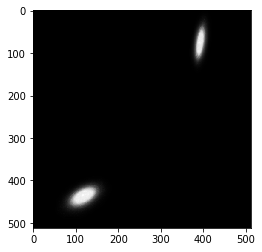

In [11]:
%matplotlib inline
plt.imshow(X2[3, 6, :, :, 0].astype(np.float32), cmap='gist_gray')
plt.show()

In [12]:
X.shape, X.dtype

((994, 512, 512, 1), dtype('float16'))

In [13]:
def decode_prediction(pred, k=2):
    encoder = sklearn.preprocessing.LabelEncoder()
    encoder.classes_ = np.load('models_saved/label_encoder_classes.npy')
    
    pred_labels_t = np.zeros((pred.shape[0], k), dtype=np.int)
    pred_labels_cpos = np.zeros((pred.shape[0], k), dtype=np.int)
    pred_proba = np.zeros((pred.shape[0], k), dtype=np.float)  # t and cpos share one proba
    
    proba_argsorted = np.argsort(pred, axis=1)
    for ranking in range(1, k+1):
        pred_labels_combined = encoder.inverse_transform(proba_argsorted[:, -ranking])
        print(pred_labels_combined)
        for i in range(pred_labels_combined.shape[0]):
            labels_tokens = pred_labels_combined[i].split('_')
            pred_labels_t[i,ranking-1] = int(labels_tokens[0])
            pred_labels_cpos[i,ranking-1] = int(labels_tokens[1])
            pred_proba[i, ranking-1] = pred[i, proba_argsorted[i, -ranking]]

    return pred_labels_t, pred_labels_cpos, pred_proba
    
pred_t, pred_cpos, pred_proba = decode_prediction(model.predict(X.astype(np.float), batch_size=2))
print(pred_t.shape, pred_cpos.shape, pred_proba.shape)
print(pred_proba)
print(pred_t)

['0_0' '1_0' '2_0' '3_0' '4_0' '5_0' '6_0' '7_0' '8_0' '9_0' '10_0' '11_0'
 '12_0' '13_0' '14_0' '15_0' '16_0' '17_0' '18_0' '19_0' '20_0' '21_0'
 '22_0' '23_0' '24_0' '25_0' '26_0' '27_0' '28_0' '29_0' '30_0' '31_0'
 '32_0' '33_0' '34_0' '35_0' '36_0' '37_0' '38_0' '39_0' '40_0' '41_0'
 '42_0' '43_0' '44_0' '45_0' '46_0' '47_0' '48_0' '49_0' '50_0' '51_0'
 '52_0' '53_0' '54_0' '55_0' '56_0' '57_0' '58_0' '59_0' '60_0' '61_0'
 '62_0' '63_0' '65_0' '65_0' '66_0' '67_0' '68_0' '69_0' '70_0' '0_1'
 '1_1' '2_1' '3_1' '4_1' '5_1' '6_1' '7_1' '8_1' '9_1' '10_1' '11_1'
 '12_1' '13_1' '14_1' '15_1' '16_1' '17_1' '18_1' '19_1' '20_1' '21_1'
 '22_1' '23_1' '24_1' '25_1' '26_1' '27_1' '28_1' '29_1' '30_1' '31_1'
 '32_1' '33_1' '34_1' '35_1' '36_1' '37_1' '38_1' '39_1' '40_1' '41_1'
 '42_1' '43_1' '44_1' '45_1' '46_1' '47_1' '48_1' '49_1' '50_1' '51_1'
 '52_1' '53_1' '54_1' '55_1' '56_1' '57_1' '58_1' '59_1' '60_1' '61_1'
 '62_1' '63_1' '64_1' '65_1' '66_1' '67_1' '68_1' '70_1' '70_1' '0_2'
 '1_2'

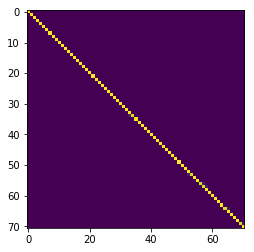

In [14]:
confusion_matrix = sklearn.metrics.confusion_matrix(Y, pred_t[:,0])
plt.imshow(confusion_matrix)
plt.show()

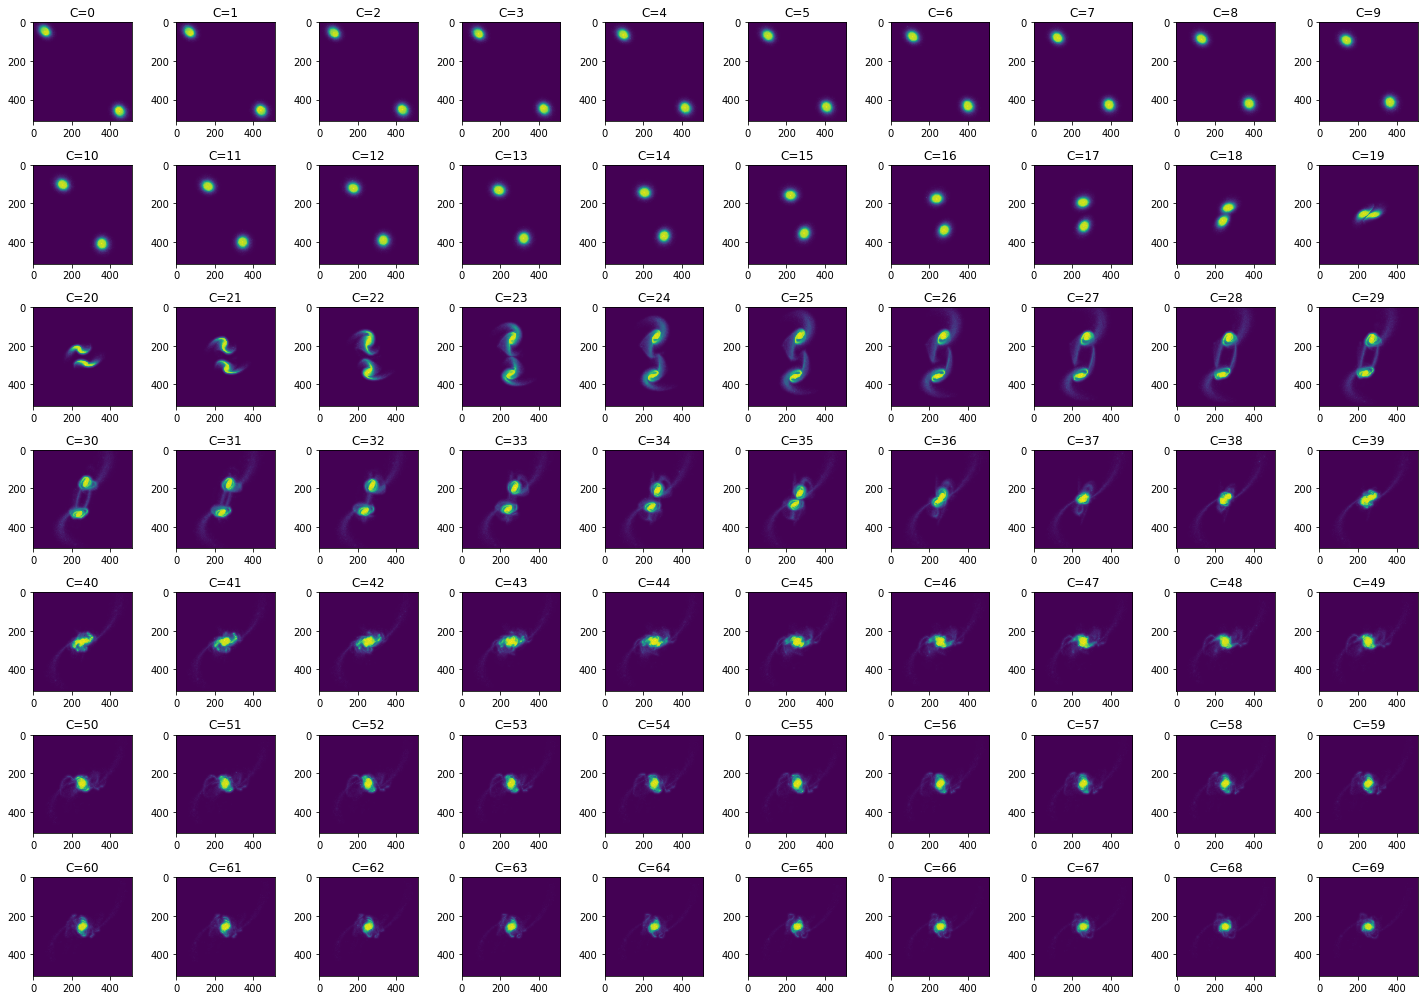

In [15]:
plt.figure(2, figsize=(20, 14))
for i in range(0, 70):
    ax = plt.subplot(7, 10, i+1)
    ax.imshow(X2[4, i, :, :, 0].astype(np.float32))
    ax.set_title('C=%d' % i)
plt.tight_layout()
plt.show()

In [16]:
img_list = glob.glob('validation_images/*.jpg')
print(img_list)

['validation_images/hst_arp240_ngc_5257.jpg', 'validation_images/hst_arp142.jpg', 'validation_images/hst_arp256.jpg', 'validation_images/hst_ugc8335_arp238.jpg', 'validation_images/hst_arp194.jpg', 'validation_images/hst_arp188.jpg', 'validation_images/hst_arp273.jpg', 'validation_images/hst_ngc4038_ngc4039.jpg', 'validation_images/hst_arp148.jpg', 'validation_images/hst_ngc2623.jpg', 'validation_images/hst_ngc4676.jpg', 'validation_images/hst_ic2163_ngc2207.jpg', 'validation_images/hst_arp293_ngc6285_ngc6286.jpg', 'validation_images/hst_arp87.jpg']


In [19]:
obs_imgs = []
obs_imgs_title = []
for img_name in img_list:
    im = cv2.imread(img_name)
    im_grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_resized = cv2.resize(im_grey, (img_size,img_size))
    print(img_name, im_resized.shape)
    obs_imgs.append((im_resized.reshape(img_size,img_size,1)/255).astype(np.float32))
    obs_imgs_title.append(os.path.basename(img_name))
print(obs_imgs_title)

validation_images/hst_arp240_ngc_5257.jpg (512, 512)
validation_images/hst_arp142.jpg (512, 512)
validation_images/hst_arp256.jpg (512, 512)
validation_images/hst_ugc8335_arp238.jpg (512, 512)
validation_images/hst_arp194.jpg (512, 512)
validation_images/hst_arp188.jpg (512, 512)
validation_images/hst_arp273.jpg (512, 512)
validation_images/hst_ngc4038_ngc4039.jpg (512, 512)
validation_images/hst_arp148.jpg (512, 512)
validation_images/hst_ngc2623.jpg (512, 512)
validation_images/hst_ngc4676.jpg (512, 512)
validation_images/hst_ic2163_ngc2207.jpg (512, 512)
validation_images/hst_arp293_ngc6285_ngc6286.jpg (512, 512)
validation_images/hst_arp87.jpg (512, 512)
['hst_arp240_ngc_5257.jpg', 'hst_arp142.jpg', 'hst_arp256.jpg', 'hst_ugc8335_arp238.jpg', 'hst_arp194.jpg', 'hst_arp188.jpg', 'hst_arp273.jpg', 'hst_ngc4038_ngc4039.jpg', 'hst_arp148.jpg', 'hst_ngc2623.jpg', 'hst_ngc4676.jpg', 'hst_ic2163_ngc2207.jpg', 'hst_arp293_ngc6285_ngc6286.jpg', 'hst_arp87.jpg']


In [20]:
pred_obs = model.predict(np.array(obs_imgs), batch_size=2)
print(np.argmax(pred_obs, axis=1), np.max(pred_obs, axis=1))
n_pred = 3
pred_obs_classes_t, pred_obs_classes_cpos, pred_obs_proba = decode_prediction(pred_obs, k=n_pred)
print(pred_obs_proba)

[386 959 386 386 486 879 362 369 506  74 335 377 386 635] [0.6782049  0.5552571  0.13443574 0.8262676  0.69473314 0.37946203
 0.84783095 0.71829516 0.35200524 0.09954102 0.27748606 0.09845975
 0.49871957 0.9065859 ]
['34_4' '7_3' '34_4' '34_4' '40_6' '66_7' '32_8' '33_13' '42_10' '14_12'
 '30_9' '33_9' '34_4' '50_13']
['42_10' '10_13' '30_9' '34_8' '33_4' '0_11' '32_10' '39_4' '21_7' '36_4'
 '67_13' '58_8' '42_10' '50_12']
['43_10' '4_6' '26_13' '1_3' '29_7' '2_1' '32_6' '33_6' '36_6' '50_13'
 '33_13' '28_3' '24_9' '34_4']
[[0.67820489 0.08720984 0.04067596]
 [0.55525708 0.07945226 0.04260697]
 [0.13443574 0.08727635 0.08528712]
 [0.8262676  0.05077626 0.01901892]
 [0.69473314 0.04511634 0.0346955 ]
 [0.37946203 0.25014123 0.10431933]
 [0.84783095 0.10050163 0.01159067]
 [0.71829516 0.05465353 0.03959438]
 [0.35200524 0.06718548 0.05409059]
 [0.09954102 0.09048251 0.08794455]
 [0.27748606 0.0827867  0.07718807]
 [0.09845975 0.07049713 0.05337667]
 [0.49871957 0.11717631 0.05461524]
 [0

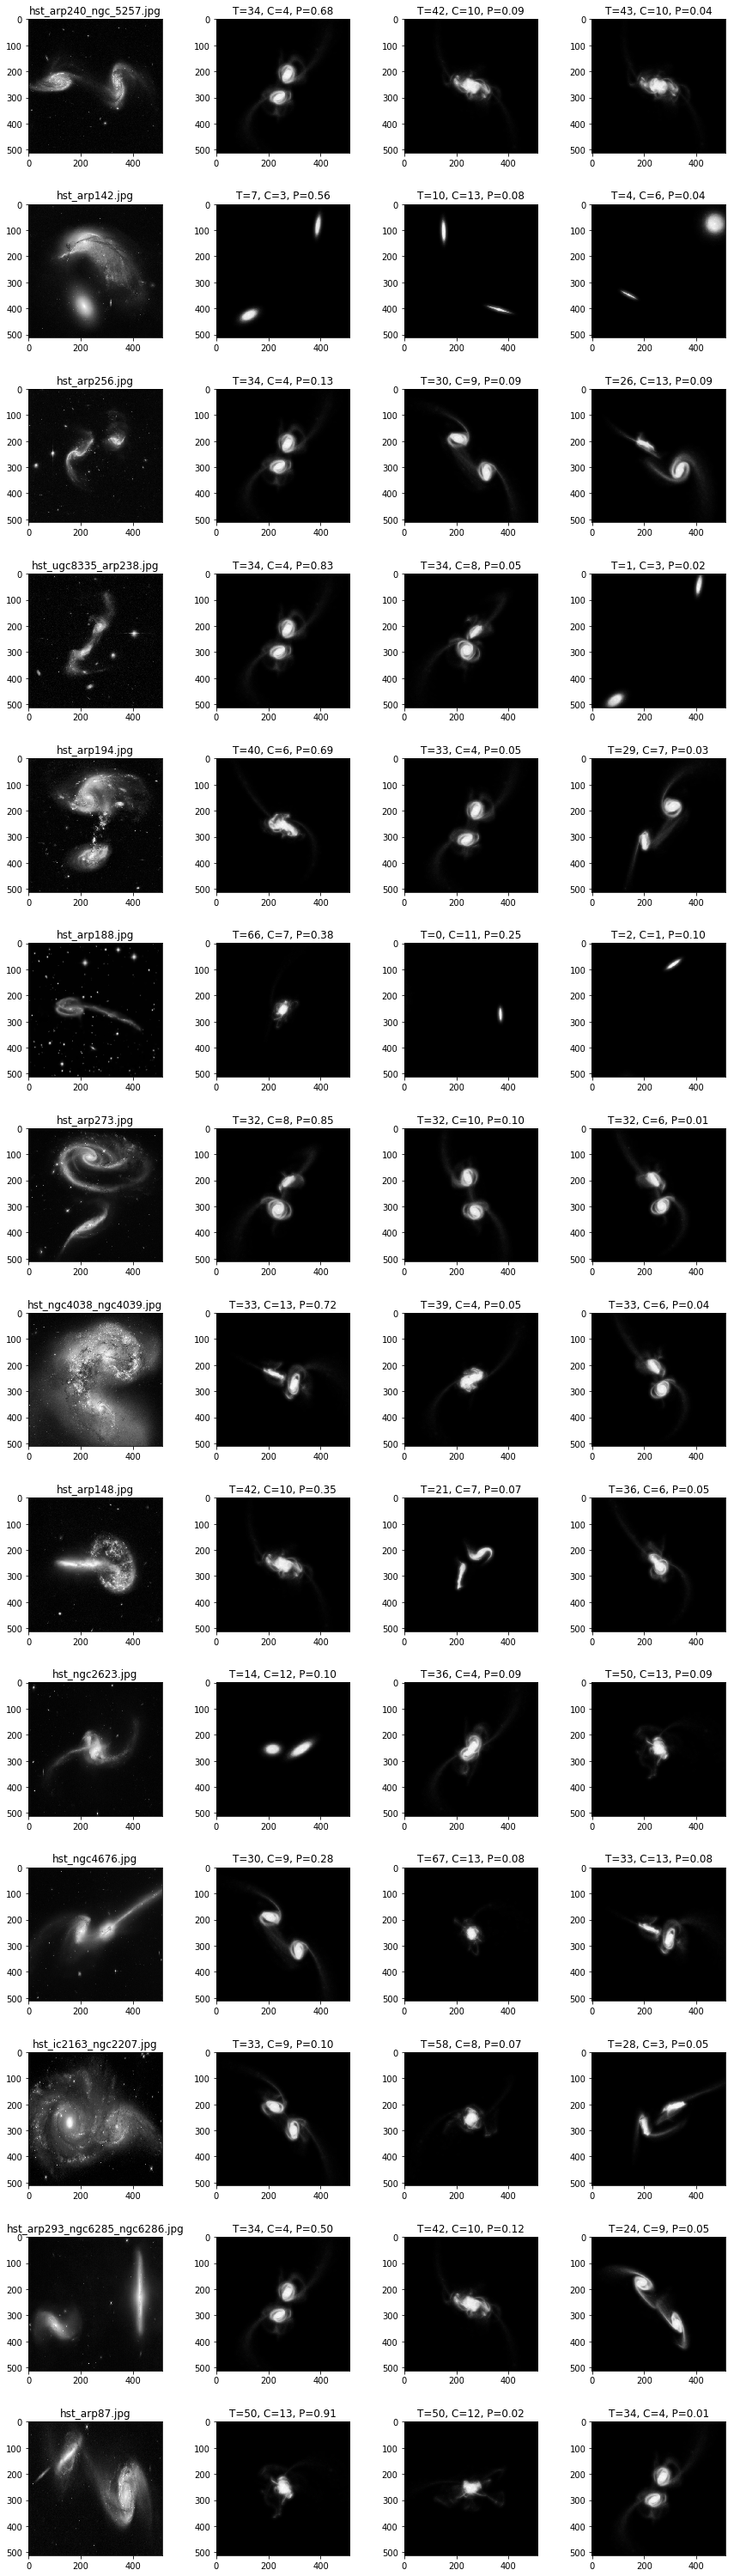

In [21]:
plt.figure(1, figsize=(3*(n_pred+1), 3*len(obs_imgs)))
for i in np.arange(0, len(obs_imgs)):
    ax = plt.subplot(len(obs_imgs), n_pred+1, (n_pred+1)*i+1)
    ax.imshow(obs_imgs[i][:, :, 0], cmap='gist_gray')
    ax.set_title(obs_imgs_title[i])
    
    for j in range(2, n_pred+2):
        ax = plt.subplot(len(obs_imgs), n_pred+1, (n_pred+1)*i+j)
        ax.imshow(X2[pred_obs_classes_cpos[i,j-2], pred_obs_classes_t[i,j-2], :, :, 0].astype(np.float32), cmap='gist_gray')
        ax.set_title('T=%d, C=%d, P=%.2f' % (pred_obs_classes_t[i,j-2],pred_obs_classes_cpos[i,j-2], pred_obs_proba[i,j-2]))
    

plt.tight_layout()